In [1]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift dill lightgbm

In [2]:
!pip install causalml

     |████████████████████████████████| 406 kB 5.0 MB/s 
     |████████████████████████████████| 564 kB 40.4 MB/s 
     |████████████████████████████████| 1.8 MB 45.2 MB/s 
     |████████████████████████████████| 718 kB 40.1 MB/s 
  Created wheel for causalml: filename=causalml-0.12.3-cp37-cp37m-linux_x86_64.whl size=1050908 sha256=d68646fd686266982f7eea82a49c0f04c52220e99a5fed6ed61d220c11588f79
  Stored in directory: /root/.cache/pip/wheels/d7/5e/47/4e965cf8e87c6c10cd7361d910acccd08a1de459f25d55fd23
Successfully built causalml


In [3]:
!pip install pylift

     |████████████████████████████████| 100 kB 4.3 MB/s 
  Created wheel for pylift: filename=pylift-0.1.5-py3-none-any.whl size=26030 sha256=3cd23c60d71e238a9a53b6f1aa68ac7949c039bc7b9d30d11953b0668c9e487e
  Stored in directory: /root/.cache/pip/wheels/c3/ec/9d/69405e922f27de16e66aada83dce7227f6fddc71639d7cfe66
Successfully built pylift


In [4]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 44 kB/s 


In [5]:
from sklift.datasets import fetch_criteo
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklift.models import TwoModels
import lightgbm as lgb
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve


# import dask.dataframe as dd
import numpy as np
import scipy as sp

import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.tlearner as tlearner

import pylift
import catboost as cb
import lightgbm as lgb

from sklearn.model_selection import train_test_split

from IPython.display import Image

seed=10

import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.tlearner as tlearner
from scipy.stats import chi2_contingency
from typing import List, Tuple

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [31]:
# Generate synthetic data using mode 1
from causalml.dataset import *
from causalml.metrics import *

y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=12, sigma=1.0)
pd.Series(treatment).value_counts()

1    5195
0    4805
dtype: int64

In [32]:
X.shape, y.shape

((10000, 12), (10000,))

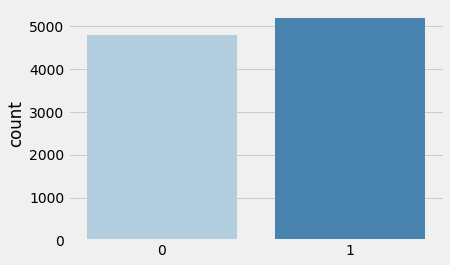

In [33]:
sns.countplot(x=pd.Series(treatment), palette = "Blues")

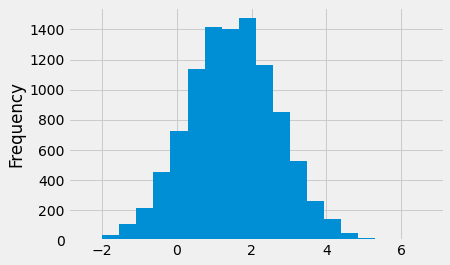

In [34]:
pd.Series(y).plot(kind="hist", bins=20)

In [35]:
target = pd.Series(y)
target.name = 'y'

In [165]:
X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    X,
    treatment,
    target,
    test_size=0.3,
    random_state=31
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (7000, 12)
Validation shape: (3000, 12)


In [166]:
df_all_scores = pd.DataFrame()
df_all_metrics= pd.DataFrame()

df_all_metrics['model'] = 'default'
df_all_metrics['auuc'] = 'default'
df_all_metrics['qini'] = 'default'

[18:04:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(3000, 1) (1, 3)


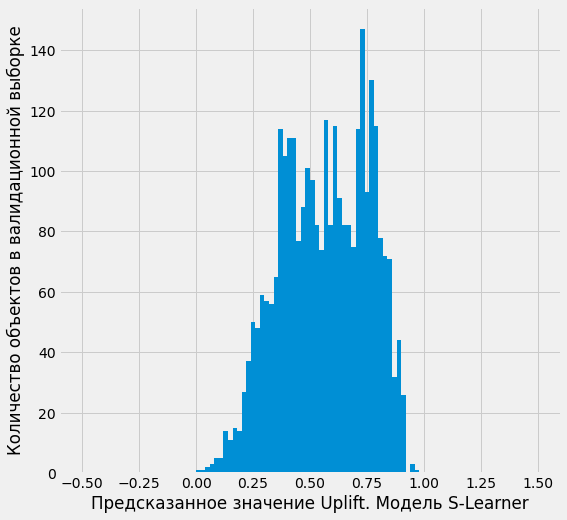

In [167]:
learner_s = BaseSRegressor(XGBRegressor(), control_name=0)

learner_s.fit(
    X=X_train,
    treatment=trmnt_train,
    y=y_train
)

s_learner_pred = pd.DataFrame(learner_s.predict(X_val))
s_learner_pred = s_learner_pred.rename(columns={0:'S-Learner'})

s_learner_pred = s_learner_pred.join(pd.Series(trmnt_val).rename('treatment').reset_index(drop=True)) # ['treatment']
s_learner_pred = s_learner_pred.join(pd.Series(y_val).rename('target').reset_index(drop=True)) # ['visit']

# add scores to total df
df_all_scores['s_learner_pred'] = s_learner_pred['S-Learner']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 
                       'model' : 'S-Learner',
                       'auuc' : cmetrics.auuc_score(s_learner_pred, treatment_col='treatment', outcome_col='target')['S-Learner'],
                       'qini' : cmetrics.qini_score(s_learner_pred, treatment_col='treatment', outcome_col='target', normalize=True)['S-Learner']
}, ignore_index=True)

print(df_all_scores.shape, df_all_metrics.shape)

plt.figure(figsize=(8, 8))
plt.hist(s_learner_pred['S-Learner'], range=(-0.5, 1.5), bins=100)
plt.xlabel("Предсказанное значение Uplift. Модель S-Learner")
plt.ylabel("Количество объектов в валидационной выборке")
plt.show()

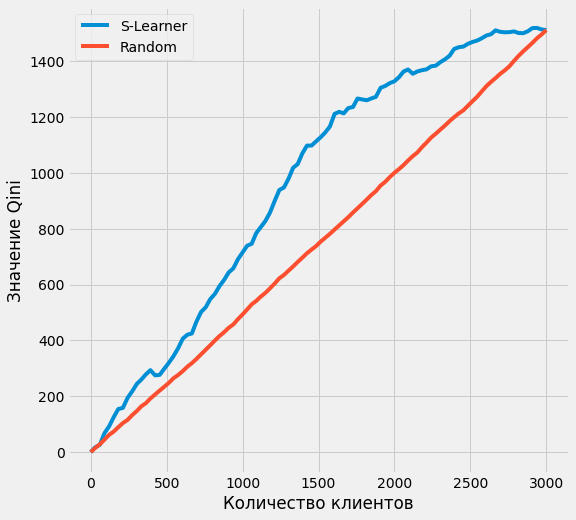

In [216]:
cmetrics.plot_qini(
    s_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Значение Qini")
plt.show()

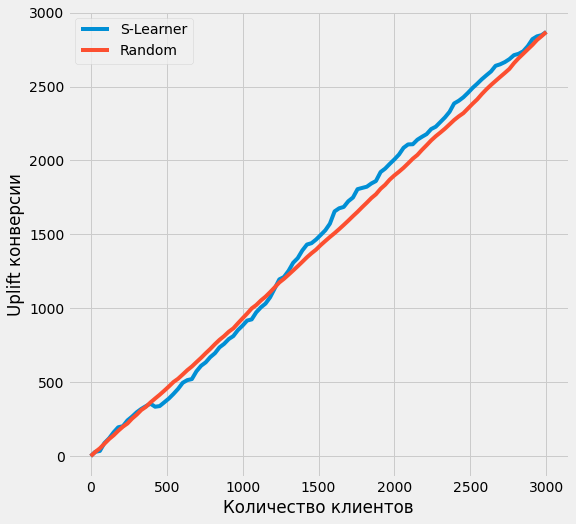

In [168]:
cmetrics.plot_gain(
    s_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Uplift конверсии")
plt.show()

In [169]:
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from xgboost import XGBRegressor, XGBClassifier

learner_t = BaseTRegressor(XGBRegressor(), control_name=0)

learner_t.fit(
    X=X_train,
    treatment=trmnt_train,
    y=y_train
)

[18:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [170]:
t_learner_pred = pd.DataFrame(learner_t.predict(X_val))
t_learner_pred = t_learner_pred.rename(columns={0:'T-Learner'})

t_learner_pred = t_learner_pred.join(pd.Series(trmnt_val).rename('treatment').reset_index(drop=True)) # ['treatment']
t_learner_pred = t_learner_pred.join(pd.Series(y_val).rename('target').reset_index(drop=True)) # ['visit']

In [63]:
t_learner_pred.head()

,T-Learner,treatment,target
0,0.450102,0,0.733641
1,0.481133,0,0.250769
2,0.934164,1,0.493581
3,0.737732,1,2.771665
4,0.379151,0,1.399004


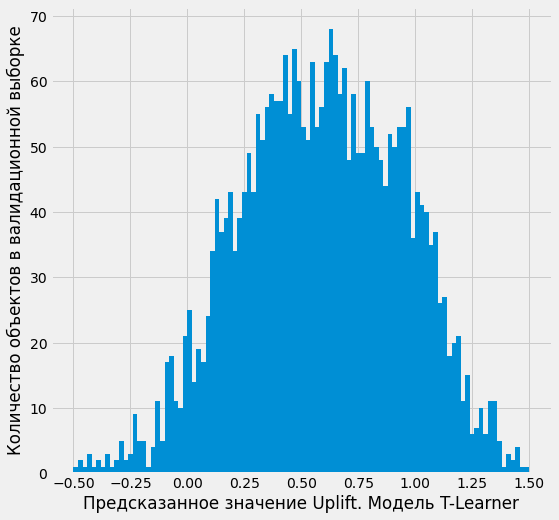

In [171]:
С

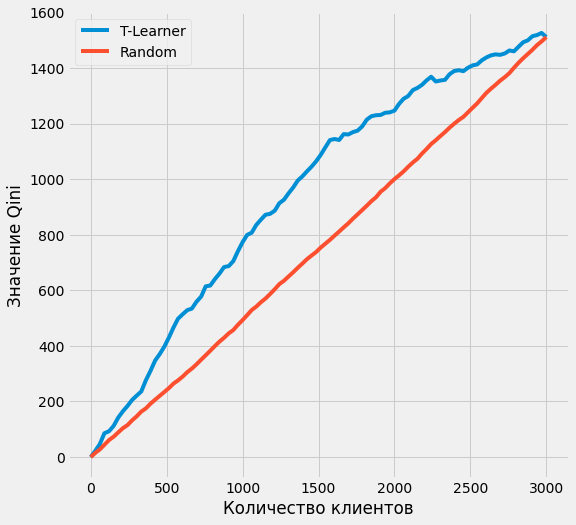

In [215]:
cmetrics.plot_qini(
    t_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Значение Qini")
plt.show()

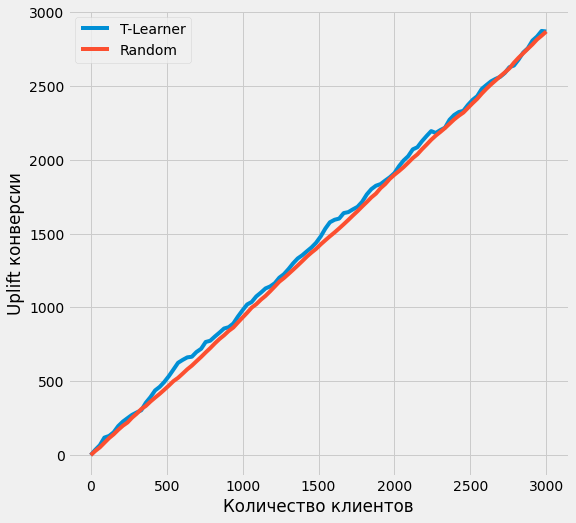

In [172]:
cmetrics.plot_gain(
    t_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Uplift конверсии")
plt.show()

In [173]:
# add scores to total df
df_all_scores['t_learner_pred'] = t_learner_pred['T-Learner']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 
                       'model' : 'T-Learner',
                       'auuc' : cmetrics.auuc_score(t_learner_pred, treatment_col='treatment', outcome_col='target')['T-Learner'],
                       'qini' : cmetrics.qini_score(t_learner_pred, treatment_col='treatment', outcome_col='target', normalize=True)['T-Learner']
}, ignore_index=True)

print(df_all_scores.shape, df_all_metrics.shape)

(3000, 2) (2, 3)


In [174]:
df_all_metrics.head()

,model,auuc,qini
0,S-Learner,0.506033,0.139663
1,T-Learner,0.506692,0.134653


[18:04:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(3000, 3) (3, 3)


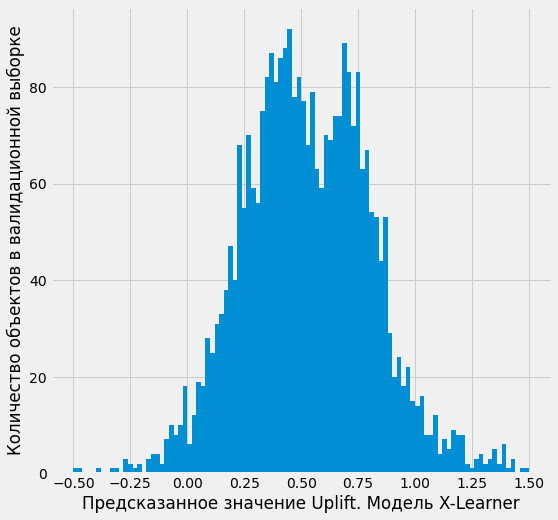

In [175]:
learner_x = BaseXRegressor(XGBRegressor(), control_name=0)

learner_x.fit(
    X=X_train,
    treatment=trmnt_train,
    y=y_train
)

x_learner_pred = pd.DataFrame(learner_x.predict(X_val))
x_learner_pred = x_learner_pred.rename(columns={0:'X-Learner'})

x_learner_pred = x_learner_pred.join(pd.Series(trmnt_val).rename('treatment').reset_index(drop=True)) # ['treatment']
x_learner_pred = x_learner_pred.join(pd.Series(y_val).rename('target').reset_index(drop=True)) # ['visit']

# add scores to total df
df_all_scores['x_learner_pred'] = x_learner_pred['X-Learner']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 
                       'model' : 'X-Learner',
                       'auuc' : cmetrics.auuc_score(x_learner_pred, treatment_col='treatment', outcome_col='target')['X-Learner'],
                       'qini' : cmetrics.qini_score(x_learner_pred, treatment_col='treatment', outcome_col='target', normalize=True)['X-Learner']
}, ignore_index=True)

print(df_all_scores.shape, df_all_metrics.shape)

plt.figure(figsize=(8, 8))
plt.hist(x_learner_pred['X-Learner'], range=(-0.5, 1.5), bins=100)
plt.xlabel("Предсказанное значение Uplift. Модель X-Learner")
plt.ylabel("Количество объектов в валидационной выборке")
plt.show()

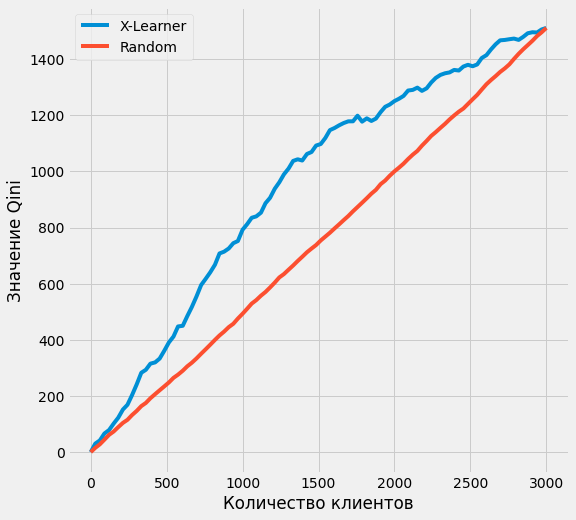

In [214]:
cmetrics.plot_qini(
    x_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Значение Qini")
plt.show()

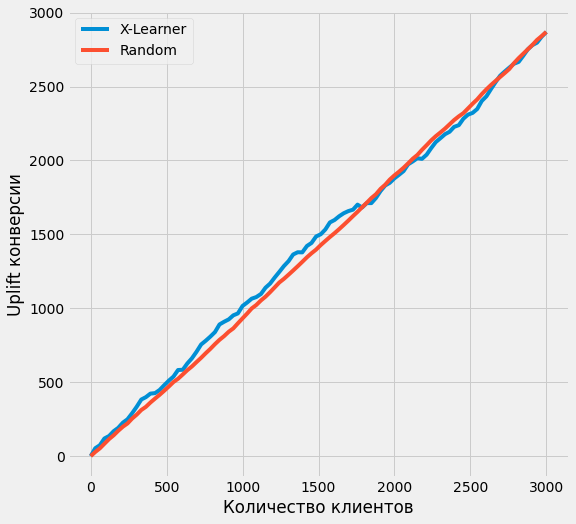

In [176]:
cmetrics.plot_gain(
    x_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Uplift конверсии")
plt.show()

In [ ]:
# R-Learner

[18:05:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(3000, 4) (4, 3)


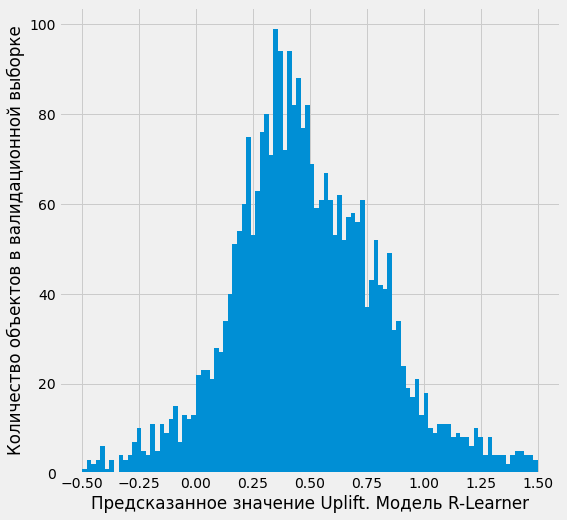

In [177]:
learner_r = BaseRRegressor(XGBRegressor(), control_name=0)

learner_r.fit(
    X=X_train,
    treatment=trmnt_train,
    y=y_train
)

r_learner_pred = pd.DataFrame(learner_r.predict(X_val))
r_learner_pred = r_learner_pred.rename(columns={0:'R-Learner'})

r_learner_pred = r_learner_pred.join(pd.Series(trmnt_val).rename('treatment').reset_index(drop=True)) # ['treatment']
r_learner_pred = r_learner_pred.join(pd.Series(y_val).rename('target').reset_index(drop=True)) # ['visit']

# add scores to total df
df_all_scores['r_learner_pred'] = r_learner_pred['R-Learner']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 
                       'model' : 'R-Learner',
                       'auuc' : cmetrics.auuc_score(r_learner_pred, treatment_col='treatment', outcome_col='target')['R-Learner'],
                       'qini' : cmetrics.qini_score(r_learner_pred, treatment_col='treatment', outcome_col='target', normalize=True)['R-Learner']
}, ignore_index=True)

print(df_all_scores.shape, df_all_metrics.shape)

plt.figure(figsize=(8, 8))
plt.hist(r_learner_pred['R-Learner'], range=(-0.5, 1.5), bins=100)
plt.xlabel("Предсказанное значение Uplift. Модель R-Learner")
plt.ylabel("Количество объектов в валидационной выборке")
plt.show()

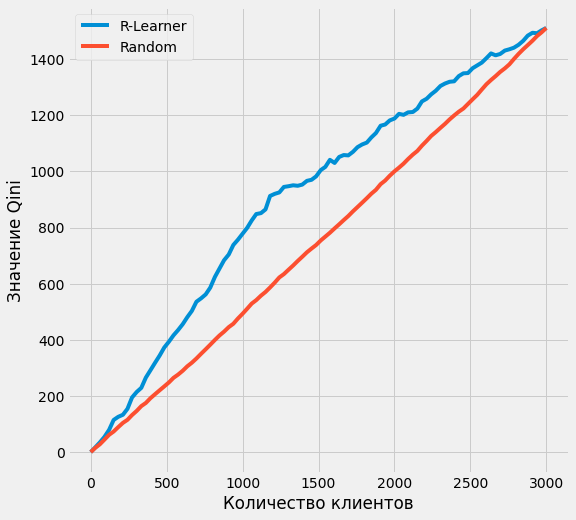

In [213]:
cmetrics.plot_qini(
    r_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Значение Qini")
plt.show()

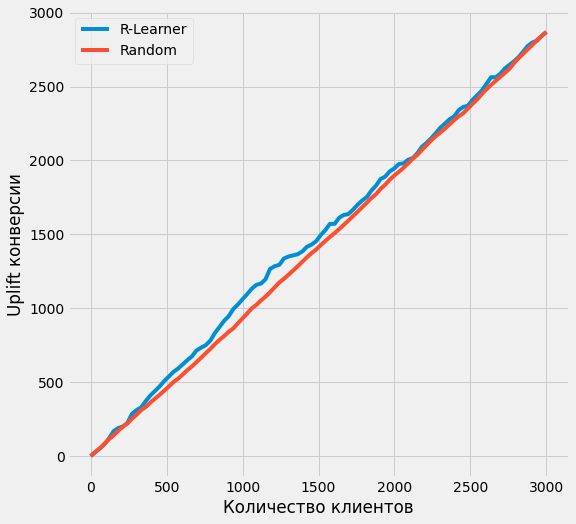

In [178]:
cmetrics.plot_gain(
    r_learner_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Uplift конверсии")
plt.show()

In [182]:
df_all_scores = df_all_scores.join(pd.Series(trmnt_val).rename('treatment').reset_index(drop=True))
df_all_scores = df_all_scores.join(pd.Series(y_val).rename('target').reset_index(drop=True))
print(df_all_scores.shape)

(3000, 6)


In [183]:
df_all_scores.head()

,s_learner_pred,t_learner_pred,x_learner_pred,r_learner_pred,treatment,target
0,0.564327,0.450102,0.371749,0.100685,0,0.733641
1,0.530108,0.481133,0.355110,0.239244,0,0.250769
2,0.720161,0.934164,0.858473,0.903402,1,0.493581
3,0.568310,0.737732,0.580014,0.471086,1,2.771665
4,0.433501,0.379151,0.442932,0.344744,0,1.399004


In [186]:
df_all_scores.columns = ['S-Learner', 'T-Learner', 'X-Learner', 'R-Learner', 'treatment', 'target']

In [217]:
df_all_metrics.head()

,model,auuc,qini
0,S-Learner,0.506033,0.139663
1,T-Learner,0.506692,0.134653
2,X-Learner,0.503233,0.133619
3,R-Learner,0.512655,0.107578


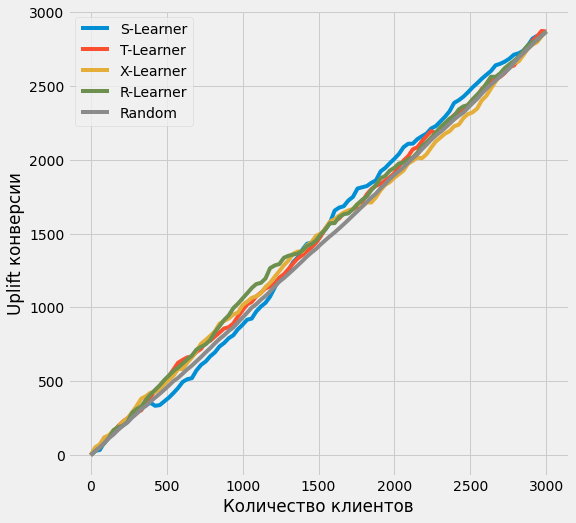

In [187]:
cmetrics.plot_gain(
    df_all_scores,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Uplift конверсии")
plt.show()

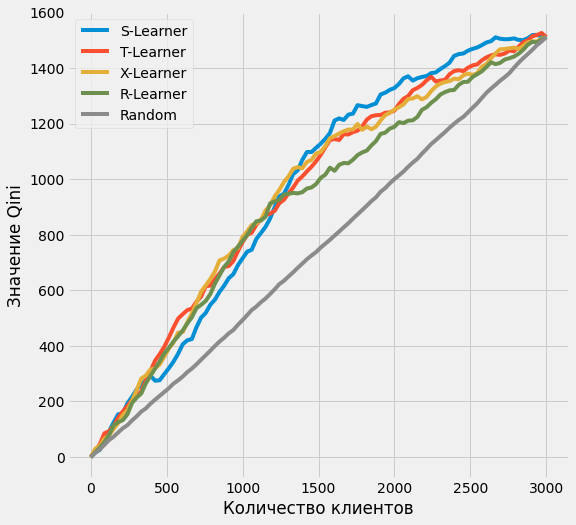

In [212]:
cmetrics.plot_qini(
    df_all_scores,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Значение Qini")
plt.show()

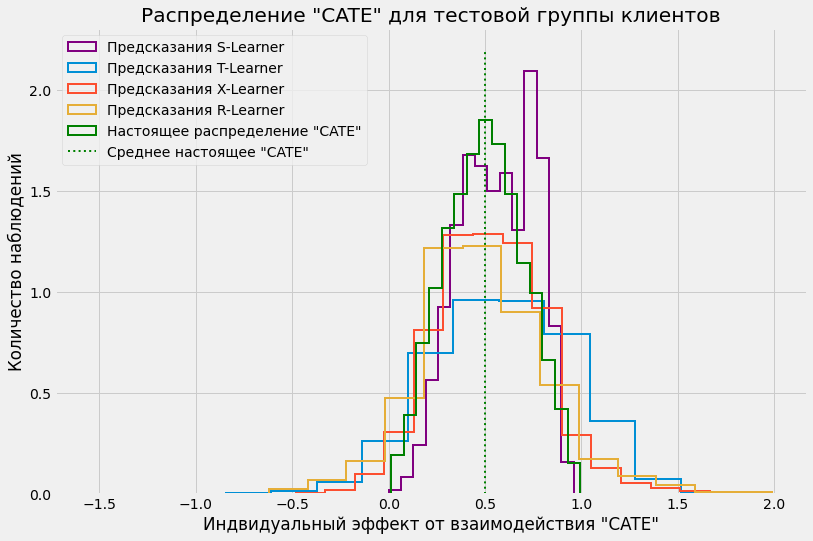

In [211]:
groups = learner_r._classes

alpha = 1
linewidth = 2
bins = 15

for group,idx in sorted(groups.items(), key=lambda x: x[1]):
    plt.figure(figsize=(12,8))
    plt.hist(df_all_scores['S-Learner'], alpha=alpha, bins=bins, label='Предсказания S-Learner',
             histtype='step', linewidth=linewidth, density=True, color='purple',)
    plt.hist(df_all_scores['T-Learner'], alpha=alpha, bins=bins, label='Предсказания T-Learner',
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(df_all_scores['X-Learner'], alpha=alpha, bins=bins, label='Предсказания X-Learner',
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(df_all_scores['R-Learner'], alpha=alpha, bins=bins, label='Предсказания R-Learner',
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(tau, alpha=alpha, bins=bins, label='Настоящее распределение "CATE"',
             histtype='step', linewidth=linewidth, color='green', density=True)
    plt.vlines(tau.mean(), 0, plt.axes().get_ylim()[1], label='Среднее настоящее "CATE"',
               linestyles='dotted', linewidth=linewidth, color='green')
    
    plt.title('Распределение "CATE" для тестовой группы клиентов')
    plt.xlabel('Индвидуальный эффект от взаимодействия "CATE"')
    plt.ylabel('Количество наблюдений')
    _=plt.legend()

In [93]:
# Uplift Tree
import causalml.inference.tree as ctree

In [155]:
# X_train = pd.DataFrame(X_train)
# y_train['index1'] = y_train.index
# X_train.index = y_train['index1']
# y_train = y_train.drop('index1')
# X_train.head()

In [156]:
# cols = ['Col_1', 'Col_2', 'Col_3', 'Col_4', 'Col_5', 'Col_6', 'Col_7', 'Col_8', 'Col_9', 'Col_10', 'Col_11', 'Col_12']
# X_train.columns = cols
# X_train.head()

In [157]:
# y_train.head()
# y_train = y_train.astype(float)

In [158]:
# trmnt_train

In [159]:
# model_tree = ctree.CausalTreeRegressor(
#     control_name=0,
#     # evaluationFunction='KL',
#     # n_estimators=20,
#     max_depth=3,
#     min_samples_leaf=500
# )
# model_tree.fit(
#     X=X_train.values,
#     treatment=trmnt_train,
#     y=y_train.values
# )

In [160]:
# cols_features = X_train.columns

# graph = ctree.uplift_tree_plot(model_tree.fitted_uplift_tree, cols_features)
# Image(graph.create_png())

(3000, 4) (11, 3)


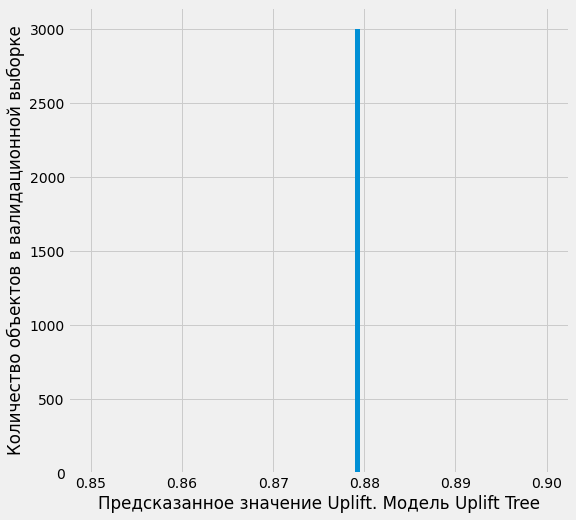

In [147]:
tree_pred = pd.DataFrame(model_tree.predict(X_val))
tree_pred = tree_pred.rename(columns={0:'Uplift Tree'})

tree_pred = tree_pred.join(pd.Series(trmnt_val).rename('treatment').reset_index(drop=True)) # ['treatment']
tree_pred = tree_pred.join(pd.Series(y_val).rename('target').reset_index(drop=True)) # ['visit']

# add scores to total df
df_all_scores['tree_pred'] = tree_pred['Uplift Tree']
# add metrics to total df 
df_all_metrics = df_all_metrics.append({ 
                       'model' : 'Uplift Tree',
                       'auuc' : cmetrics.auuc_score(tree_pred, treatment_col='treatment', outcome_col='target')['Uplift Tree'],
                       'qini' : cmetrics.qini_score(tree_pred, treatment_col='treatment', outcome_col='target', normalize=True)['Uplift Tree']
}, ignore_index=True)

print(df_all_scores.shape, df_all_metrics.shape)

plt.figure(figsize=(8, 8))
plt.hist(tree_pred['Uplift Tree'], range=(0.85, 0.9), bins=100)
plt.xlabel("Предсказанное значение Uplift. Модель Uplift Tree")
plt.ylabel("Количество объектов в валидационной выборке")
plt.show()

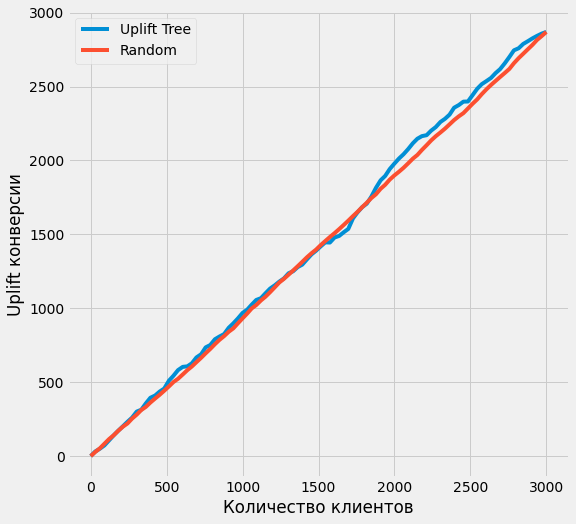

In [140]:
cmetrics.plot_gain(
    tree_pred,
    treatment_col='treatment',
    outcome_col='target'
)
plt.xlabel("Количество клиентов")
plt.ylabel("Uplift конверсии")
plt.show()